# Data Preparation for Prophet Model - Direction Prediction with Feature Selection

## Objective
This notebook prepares the cleaned stock data for the Prophet model with a focus on **price direction prediction** rather than exact price prediction. It includes feature selection to remove redundant features and improve model performance.

## Process
1. Load the cleaned data from `data/cleaned/`
2. Format data for Prophet (rename columns, add features)
3. Apply feature selection to remove redundant features
4. Create separate datasets for each prediction horizon (day, week, month)
5. Save prepared files in the proper directory structure
6. Analyze feature importance and data quality

## Notes
- Prophet requires a date column named 'ds' and a target column named 'y'
- For direction prediction, 'y' will be binary (0=down, 1=up)
- Prophet treats this as a regression problem, but we can interpret values between 0-1 as probabilities
- We'll apply feature selection to keep only the most relevant features for prediction

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.max_columns', None)
%matplotlib inline

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Define Directories

First, let's set up the input and output directories.

In [8]:
# Input directory (where cleaned data is stored)
input_dir = '../data/cleaned/'

# Output base directory
output_base_dir = '../data/prophet/'

# Create output directories for each prediction period
periods = ['day', 'week', 'month']
output_dirs = {}

for period in periods:
    output_dirs[period] = os.path.join(output_base_dir, period)
    os.makedirs(output_dirs[period], exist_ok=True)
    print(f"Created directory: {output_dirs[period]}")

Created directory: ../data/prophet/day
Created directory: ../data/prophet/week
Created directory: ../data/prophet/month


## 2. Define Feature Engineering Function

This function will prepare the data for Prophet and create features relevant for direction prediction.

In [9]:
def prepare_for_prophet(df, prediction_period='day'):
    """
    Prepare stock data for Prophet model for direction prediction.
    
    Parameters:
    - df: DataFrame with cleaned stock data
    - prediction_period: 'day', 'week', or 'month' for different prediction horizons
    
    Returns:
    - DataFrame formatted for Prophet
    """
    # Make a copy to avoid modifying the original DataFrame
    df_prophet = df.copy()
    
    # Make sure date is in datetime format
    df_prophet['date'] = pd.to_datetime(df_prophet['date'])
    
    # Rename date column to 'ds' as required by Prophet
    df_prophet = df_prophet.rename(columns={'date': 'ds'})
    
    # Set the appropriate target variable based on prediction period
    if prediction_period == 'day':
        df_prophet = df_prophet.rename(columns={'next_day_direction': 'y'})
        # Keep the original target for reference (not used in model but useful for evaluation)
        df_prophet['next_day_close'] = df_prophet['next_day_close']
    elif prediction_period == 'week':
        df_prophet = df_prophet.rename(columns={'next_week_direction': 'y'})
        df_prophet['next_week_avg'] = df_prophet['next_week_avg']
    elif prediction_period == 'month':
        df_prophet = df_prophet.rename(columns={'next_month_direction': 'y'})
        df_prophet['next_month_avg'] = df_prophet['next_month_avg']
    else:
        raise ValueError("prediction_period must be 'day', 'week', or 'month'")
    
    # Feature Engineering: Create additional features useful for direction prediction
    
    # 1. Distance from moving averages (as a percentage)
    df_prophet['close_ma5_pct'] = (df_prophet['close'] - df_prophet['ma5']) / df_prophet['ma5']
    df_prophet['close_ma20_pct'] = (df_prophet['close'] - df_prophet['ma20']) / df_prophet['ma20']
    df_prophet['close_ma50_pct'] = (df_prophet['close'] - df_prophet['ma50']) / df_prophet['ma50']
    
    # 2. Rolling returns for different windows
    df_prophet['rolling_return_3d'] = df_prophet['return'].rolling(window=3).sum()
    df_prophet['rolling_return_7d'] = df_prophet['return'].rolling(window=7).sum()
    
    # 3. Volatility ratio (short-term to long-term) - useful for gauging changing market conditions
    df_prophet['volatility_10d'] = df_prophet['return'].rolling(window=10).std()
    df_prophet['volatility_ratio'] = df_prophet['volatility_10d'] / df_prophet['volatility']
    
    # 4. Volume relative to its moving average - can signal potential direction changes
    df_prophet['volume_ratio'] = df_prophet['volume'] / df_prophet['volume_ma20']
    
    # 5. Add RSI-based features if available
    if 'rsi' in df_prophet.columns:
        df_prophet['rsi_signal'] = (df_prophet['rsi'] > 50).astype(int)  # Above 50 = bullish
        df_prophet['rsi_overbought'] = (df_prophet['rsi'] > 70).astype(int)  # Overbought
        df_prophet['rsi_oversold'] = (df_prophet['rsi'] < 30).astype(int)  # Oversold
    
    # 6. Moving average crossover signals
    if 'ma5_cross_ma20' in df_prophet.columns:
        # Already in the data from our cleaning notebook
        df_prophet['ma5_cross_ma20_signal'] = df_prophet['ma5_cross_ma20']
    else:
        # Create it if not already in the data
        df_prophet['ma5_cross_ma20_signal'] = (df_prophet['ma5'] > df_prophet['ma20']).astype(int)
    
    if 'ma20_cross_ma50' in df_prophet.columns:
        df_prophet['ma20_cross_ma50_signal'] = df_prophet['ma20_cross_ma50']
    else:
        df_prophet['ma20_cross_ma50_signal'] = (df_prophet['ma20'] > df_prophet['ma50']).astype(int)
    
    # 7. Price momentum: current return compared to rolling average return
    df_prophet['return_momentum'] = df_prophet['return'] / df_prophet['return'].rolling(window=10).mean()
    
    # 8. Trend strength indicator
    df_prophet['trend_strength'] = abs(df_prophet['close_ma20_pct']) / df_prophet['volatility']
    
    # Fill NaN values created by rolling calculations
    df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
    
    # Replace any remaining NaNs or infinities with 0
    df_prophet = df_prophet.replace([np.inf, -np.inf], np.nan).fillna(0)
    
    # Base features to always keep
    base_columns = [
        'ds',                      # Date
        'y',                       # Target variable (direction)
        'symbol'                   # Stock symbol
    ]
    
    # Add reference targets if available (original prediction targets before binary conversion)
    if prediction_period == 'day' and 'next_day_close' in df_prophet.columns:
        base_columns.append('next_day_close')
    elif prediction_period == 'week' and 'next_week_avg' in df_prophet.columns:
        base_columns.append('next_week_avg')
    elif prediction_period == 'month' and 'next_month_avg' in df_prophet.columns:
        base_columns.append('next_month_avg')
    
    # Pre-filter: Remove some obviously redundant features
    # We'll keep just one price column (close) and remove open, high, low which are highly correlated
    feature_columns = [
        'close',                   # Price - keeping only close and removing open, high, low
        'volume',                  # Volume
        'return',                  # Returns
        'ma5',                     # Moving averages - keeping all for now, will filter later
        'ma20',
        'ma50',
        'volatility',              # Volatility measures
        'volume_ma20',             # Volume moving average
        'close_ma5_pct',           # Price to MA ratio features
        'close_ma20_pct',
        'close_ma50_pct',
        'rolling_return_3d',       # Rolling returns
        'rolling_return_7d',
        'volatility_10d',          # Additional volatility measures
        'volatility_ratio',
        'volume_ratio',            # Volume features
        'ma5_cross_ma20_signal',   # MA crossover signals
        'ma20_cross_ma50_signal',
        'return_momentum',         # Momentum indicators
        'trend_strength'           # Trend strength indicator
    ]
    
    # Add RSI columns if available
    if 'rsi' in df_prophet.columns:
        feature_columns.extend(['rsi', 'rsi_signal', 'rsi_overbought', 'rsi_oversold'])
    
    # Keep only the existing columns
    all_columns = base_columns + [col for col in feature_columns if col in df_prophet.columns]
    df_prophet = df_prophet[all_columns]
    
    # Drop any remaining NaN values
    df_prophet = df_prophet.dropna()
    
    return df_prophet

## 3. Define Feature Selection Function

This function identifies and removes redundant features based on correlation analysis.

In [10]:
def remove_redundant_features(df, threshold=0.85, target_col='y'):
    """
    Identify and remove redundant features based on correlation analysis.
    
    Parameters:
    - df: DataFrame with features
    - threshold: Correlation threshold above which features are considered redundant
    - target_col: Target variable column name
    
    Returns:
    - List of features to keep
    - Dictionary of removed features with their replacements
    """
    # Select only numeric columns for correlation analysis
    numeric_df = df.select_dtypes(include=['number'])
    
    # Get correlation matrix
    corr_matrix = numeric_df.corr().abs()
    
    # Calculate correlation with target for each feature
    target_corr = corr_matrix[target_col].drop(target_col)
    
    # Find highly correlated feature pairs (excluding correlation with target)
    features = corr_matrix.index.tolist()
    to_drop = set()
    feature_replacements = {}
    
    # Iterate through the correlation matrix
    for i in range(len(features)):
        if features[i] == target_col or features[i] in to_drop:
            continue
            
        for j in range(i+1, len(features)):
            if features[j] == target_col or features[j] in to_drop:
                continue
                
            # Check if features are highly correlated
            if corr_matrix.iloc[i, j] > threshold:
                # Decide which feature to drop based on correlation with target
                feat_i, feat_j = features[i], features[j]
                corr_i = target_corr.get(feat_i, 0)
                corr_j = target_corr.get(feat_j, 0)
                
                # Keep the feature with higher correlation with target
                if corr_i >= corr_j:
                    to_drop.add(feat_j)
                    feature_replacements[feat_j] = feat_i
                else:
                    to_drop.add(feat_i)
                    feature_replacements[feat_i] = feat_j
    
    # Features to keep (excluding those marked for dropping)
    features_to_keep = [f for f in features if f not in to_drop]
    
    return features_to_keep, feature_replacements

## 4. Apply Feature Selection and Process Data

Process all stock files, apply feature selection, and save the prepared data.

In [11]:
# Get list of all stock files
stock_files = glob.glob(os.path.join(input_dir, "*.csv"))
print(f"Found {len(stock_files)} stock files to process")

# Track feature selection results across all stocks
all_feature_selections = {period: [] for period in periods}

# Process each stock file for each prediction period
for file_path in tqdm(stock_files, desc="Processing stocks"):
    # Extract symbol from filename
    symbol = os.path.basename(file_path).split('.')[0]
    print(f"\nProcessing {symbol}...")
    
    # Load data
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded data for {symbol}: {len(df)} rows")
        
        # Check if direction columns exist
        if not all(col in df.columns for col in ['next_day_direction', 'next_week_direction', 'next_month_direction']):
            print(f"Warning: {symbol} data doesn't have required direction columns. Skipping.")
            continue
        
        # Process for each prediction period
        for period in periods:
            try:
                # Step 1: Prepare data for Prophet with initial features
                df_prophet = prepare_for_prophet(df, prediction_period=period)
                print(f"\nPrepared {symbol} data for {period} direction prediction: {len(df_prophet)} rows")
                print(f"Initial feature count: {len(df_prophet.columns) - 3}")  # -3 for ds, y, symbol
                
                # Step 2: Apply feature selection
                # First, separate non-numeric columns
                numeric_cols = df_prophet.select_dtypes(include=['number']).columns
                non_numeric_cols = [col for col in df_prophet.columns if col not in numeric_cols]
                
                # Get features to keep
                features_to_keep, replacements = remove_redundant_features(
                    df_prophet[numeric_cols], 
                    threshold=0.85, 
                    target_col='y'
                )
                
                # Filter dataframe to keep only selected features
                selected_cols = non_numeric_cols + features_to_keep
                df_filtered = df_prophet[selected_cols]
                
                # Save feature selection results for analysis
                feature_info = {
                    'symbol': symbol,
                    'initial_features': len(numeric_cols) - 1,  # -1 for y
                    'kept_features': len(features_to_keep) - 1,  # -1 for y
                    'feature_list': [f for f in features_to_keep if f != 'y']
                }
                all_feature_selections[period].append(feature_info)
                
                # Print feature selection results
                print(f"After feature selection: {len(features_to_keep) - 1} features kept")  # -1 for y
                print(f"Removed {len(replacements)} redundant features")
                
                if len(replacements) > 0:
                    print("\nRedundant feature groups:")
                    replacement_groups = {}
                    for removed, kept in replacements.items():
                        if kept not in replacement_groups:
                            replacement_groups[kept] = []
                        replacement_groups[kept].append(removed)
                    
                    for kept, removed_list in replacement_groups.items():
                        print(f"  - Kept: {kept}, Removed: {', '.join(removed_list)}")
                
                # Check class balance
                up_pct = 100 * df_filtered['y'].mean()
                print(f"Class balance: {up_pct:.1f}% Up, {100-up_pct:.1f}% Down")
                
                # Save prepared data with period in the filename
                output_file = os.path.join(output_dirs[period], f"{symbol}_prophet_{period}.csv")
                df_filtered.to_csv(output_file, index=False)
                print(f"Saved {period} data to {output_file}")
                
            except Exception as e:
                print(f"Error preparing {symbol} data for {period} prediction: {str(e)}")
    
    except Exception as e:
        print(f"Error loading {symbol} data: {str(e)}")

Found 20 stock files to process


Processing stocks:   0%|          | 0/20 [00:00<?, ?it/s]


Processing PYPL...
Loaded data for PYPL: 2458 rows

Prepared PYPL data for day direction prediction: 2458 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 52.3% Up, 47.7% Down
Saved day data to ../data/prophet/day/PYPL_prophet_day.csv

Prepared PYPL data for week direction prediction: 2458 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg, close, ma20
  - Kept: close, Removed: ma5
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 55.0% Up, 45.0% Down
Saved week data to ../data/prophet/week/PYPL_prophet_week.csv


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared PYPL data for month direction prediction: 2458 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg, close, ma5, ma20
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 58.2% Up, 41.8% Down
Saved month data to ../data/prophet/month/PYPL_prophet_month.csv

Processing AMZN...
Loaded data for AMZN: 2491 rows

Prepared AMZN data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 53.6% Up, 46.4% Down
Saved day data to ../data/prophet/day/AMZN_prophet_day.csv

Prepared AMZN data for week direction prediction: 2491 rows
Initial feature count: 25


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: ma5, Removed: close
  - Kept: close, Removed: ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 56.6% Up, 43.4% Down
Saved week data to ../data/prophet/week/AMZN_prophet_week.csv

Prepared AMZN data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: ma5, Removed: close
  - Kept: close, Removed: ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 63.7% Up, 36.3% Down
Saved month data to ../data/prophet/month/AMZN_prophet_month.csv

Processing GS...
Loaded data for GS: 2491 rows


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared GS data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 51.3% Up, 48.7% Down
Saved day data to ../data/prophet/day/GS_prophet_day.csv

Prepared GS data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: next_week_avg, Removed: close, ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 53.0% Up, 47.0% Down
Saved week data to ../data/prophet/week/GS_prophet_week.csv

Prepared GS data for month direction prediction: 2491 ro

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved week data to ../data/prophet/week/NFLX_prophet_week.csv

Prepared NFLX data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 60.5% Up, 39.5% Down
Saved month data to ../data/prophet/month/NFLX_prophet_month.csv

Processing AMD...
Loaded data for AMD: 2490 rows

Prepared AMD data for day direction prediction: 2490 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 50.5% Up, 49.5% Down
Saved day data to ../data/prophet/day/AMD_prophet_day.csv

Prepared AMD dat

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: ma5, Removed: close
  - Kept: close, Removed: ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 54.8% Up, 45.2% Down
Saved week data to ../data/prophet/week/AMD_prophet_week.csv

Prepared AMD data for month direction prediction: 2490 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 56.9% Up, 43.1% Down
Saved month data to ../data/prophet/month/AMD_prophet_month.csv

Processing IBM...
Loaded data for IBM: 2491 rows

Prepared IBM data for day direction prediction: 2491 rows
Initial feature count: 25
After feature s

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared IBM data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_week_avg, Removed: close, ma5, ma20, ma50
  - Kept: volume_ratio, Removed: volume
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 54.0% Up, 46.0% Down
Saved week data to ../data/prophet/week/IBM_prophet_week.csv

Prepared IBM data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_month_avg, Removed: close, ma5, ma20, ma50
  - Kept: volume_ratio, Removed: volume
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 55.8% Up, 44.2% Down
Saved month data to ../data/prophet/month/IBM_prophet_month.csv

Processing GOOG...
Loaded data for GOOG: 2491 rows

Prepared GOOG data for day direction prediction: 2491 rows
Initial feature count: 

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved day data to ../data/prophet/day/GOOG_prophet_day.csv

Prepared GOOG data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 56.4% Up, 43.6% Down
Saved week data to ../data/prophet/week/GOOG_prophet_week.csv

Prepared GOOG data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg, close
  - Kept: close, Removed: ma5, ma20
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 61.3% Up, 38.7% Down
Saved month data to ../data/prophet/month/GOOG_prophet_month.csv

Processing T...
Loaded data for T: 2491 rows


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared T data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 52.1% Up, 47.9% Down
Saved day data to ../data/prophet/day/T_prophet_day.csv

Prepared T data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_week_avg, Removed: close, ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: close_ma20_pct, Removed: rsi
Class balance: 55.2% Up, 44.8% Down
Saved week data to ../data/prophet/week/T_prophet_week.csv

Prepared T data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant featur

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved month data to ../data/prophet/month/NVDA_prophet_month.csv

Processing NKE...
Loaded data for NKE: 2491 rows

Prepared NKE data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: close, Removed: ma5, ma50
  - Kept: ma20, Removed: close
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 50.5% Up, 49.5% Down
Saved day data to ../data/prophet/day/NKE_prophet_day.csv

Prepared NKE data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg, close, ma5
  - Kept: ma20, Removed: ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 52.2% Up, 47.8% Down


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved week data to ../data/prophet/week/NKE_prophet_week.csv

Prepared NKE data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: ma20, Removed: close, ma5
  - Kept: close, Removed: ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 53.0% Up, 47.0% Down
Saved month data to ../data/prophet/month/NKE_prophet_month.csv

Processing MSFT...
Loaded data for MSFT: 2491 rows

Prepared MSFT data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 53.6% Up, 46.4% Down


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved day data to ../data/prophet/day/MSFT_prophet_day.csv

Prepared MSFT data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 57.8% Up, 42.2% Down
Saved week data to ../data/prophet/week/MSFT_prophet_week.csv

Prepared MSFT data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 64.4% Up, 35.6% Down


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved month data to ../data/prophet/month/MSFT_prophet_month.csv

Processing TSLA...
Loaded data for TSLA: 2491 rows

Prepared TSLA data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 17 features kept
Removed 8 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5
  - Kept: ma50, Removed: next_day_close, ma20
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: close_ma20_pct, Removed: rolling_return_7d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 51.5% Up, 48.5% Down
Saved day data to ../data/prophet/day/TSLA_prophet_day.csv


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared TSLA data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg, close, ma5, ma20
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 53.2% Up, 46.8% Down
Saved week data to ../data/prophet/week/TSLA_prophet_week.csv

Prepared TSLA data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: ma20, Removed: close, ma5
  - Kept: close, Removed: ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 54.1% Up, 45.9% Down
Saved month data to ../data/prophet/month/TSLA_prophet_mo

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 54.6% Up, 45.4% Down
Saved day data to ../data/prophet/day/SPY_prophet_day.csv

Prepared SPY data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg, close
  - Kept: close, Removed: ma5
  - Kept: ma20, Removed: ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 59.9% Up, 40.1% Down
Saved week data to ../data/prophet/week/SPY_prophet_week.csv


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared SPY data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg, close, ma5
  - Kept: ma20, Removed: ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 66.0% Up, 34.0% Down
Saved month data to ../data/prophet/month/SPY_prophet_month.csv

Processing AAPL...
Loaded data for AAPL: 2491 rows

Prepared AAPL data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 52.9% Up, 47.1% Down
Saved day data to ../data/prophet/day/AAPL_prophet_day.csv

Prepared

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared INTC data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: next_day_close, Removed: close, ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 51.2% Up, 48.8% Down
Saved day data to ../data/prophet/day/INTC_prophet_day.csv

Prepared INTC data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: next_week_avg, Removed: close, ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 52.3% Up, 47.7% Down
Saved week data to ../data/prophet/week/INTC_prophet_week.csv


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared INTC data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 53.3% Up, 46.7% Down
Saved month data to ../data/prophet/month/INTC_prophet_month.csv

Processing V...
Loaded data for V: 2491 rows

Prepared V data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: close, Removed: next_day_close
  - Kept: next_day_close, Removed: ma5, ma20, ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 55.1% Up, 44.9% Down
Saved day data to ../data/prophet/day/V_prophet_day.csv

Prepared V data for week direction prediction: 2491 rows
Initial feat

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared BABA data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_week_avg, Removed: close, ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 51.2% Up, 48.8% Down
Saved week data to ../data/prophet/week/BABA_prophet_week.csv

Prepared BABA data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: next_month_avg, Removed: close, ma5, ma20, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rsi, Removed: close_ma20_pct
Class balance: 52.2% Up, 47.8% Down
Saved month data to ../data/prophet/month/BABA_prophet_month.csv

Processing META...
Loaded data for META: 2491 rows


/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared META data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: next_day_close, Removed: ma20
  - Kept: close, Removed: ma5, ma50
  - Kept: close_ma5_pct, Removed: rolling_return_3d
Class balance: 52.7% Up, 47.3% Down
Saved day data to ../data/prophet/day/META_prophet_day.csv

Prepared META data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed 5 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 55.6% Up, 44.4% Down
Saved week data to ../data/prophet/week/META_prophet_week.csv

Prepared META data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 20 features kept
Removed

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved month data to ../data/prophet/month/META_prophet_month.csv

Processing DIS...
Loaded data for DIS: 2491 rows

Prepared DIS data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: next_day_close, Removed: ma5, ma20
  - Kept: close, Removed: ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rolling_return_3d
  - Kept: rolling_return_7d, Removed: close_ma20_pct
Class balance: 50.1% Up, 49.9% Down
Saved day data to ../data/prophet/day/DIS_prophet_day.csv

Prepared DIS data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: close_ma5_pct, Remov

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet

Saved week data to ../data/prophet/week/DIS_prophet_week.csv

Prepared DIS data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 18 features kept
Removed 7 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg, close
  - Kept: ma20, Removed: ma5
  - Kept: ma5, Removed: ma50
  - Kept: volatility_10d, Removed: volatility
  - Kept: rolling_return_3d, Removed: close_ma5_pct
  - Kept: rolling_return_7d, Removed: close_ma20_pct
Class balance: 49.5% Up, 50.5% Down
Saved month data to ../data/prophet/month/DIS_prophet_month.csv

Processing BA...
Loaded data for BA: 2491 rows

Prepared BA data for day direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_day_close
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: close_ma5_pct, Removed: rollin

/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_prophet['date'] = pd.to_datetime(df_prophet['date'])
/tmp/ipykernel_10914/4037792309.py:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_prophet = df_prophet.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_10914/4037792309.py:16: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datet


Prepared BA data for week direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_week_avg, close
  - Kept: ma20, Removed: ma5
  - Kept: ma5, Removed: ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 52.7% Up, 47.3% Down
Saved week data to ../data/prophet/week/BA_prophet_week.csv

Prepared BA data for month direction prediction: 2491 rows
Initial feature count: 25
After feature selection: 19 features kept
Removed 6 redundant features

Redundant feature groups:
  - Kept: ma50, Removed: next_month_avg
  - Kept: close, Removed: ma5, ma20, ma50
  - Kept: volatility, Removed: volatility_10d
  - Kept: rolling_return_3d, Removed: close_ma5_pct
Class balance: 53.7% Up, 46.3% Down
Saved month data to ../data/prophet/month/BA_prophet_month.csv


## 5. Analyze Feature Selection Results

Let's see which features were kept most frequently across all stocks.


Day Direction Prediction: Feature Selection Summary
Average features kept: 19.1
Average feature reduction: 23.6%

Top features by selection frequency:
  volume: 100.0% of stocks
  return: 100.0% of stocks
  volume_ma20: 100.0% of stocks
  close_ma50_pct: 100.0% of stocks
  volatility_ratio: 100.0% of stocks
  ma5_cross_ma20_signal: 100.0% of stocks
  ma20_cross_ma50_signal: 100.0% of stocks
  return_momentum: 100.0% of stocks
  trend_strength: 100.0% of stocks
  rsi_signal: 100.0% of stocks


/tmp/ipykernel_10914/1553895500.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_values, y=x_values, palette='viridis')


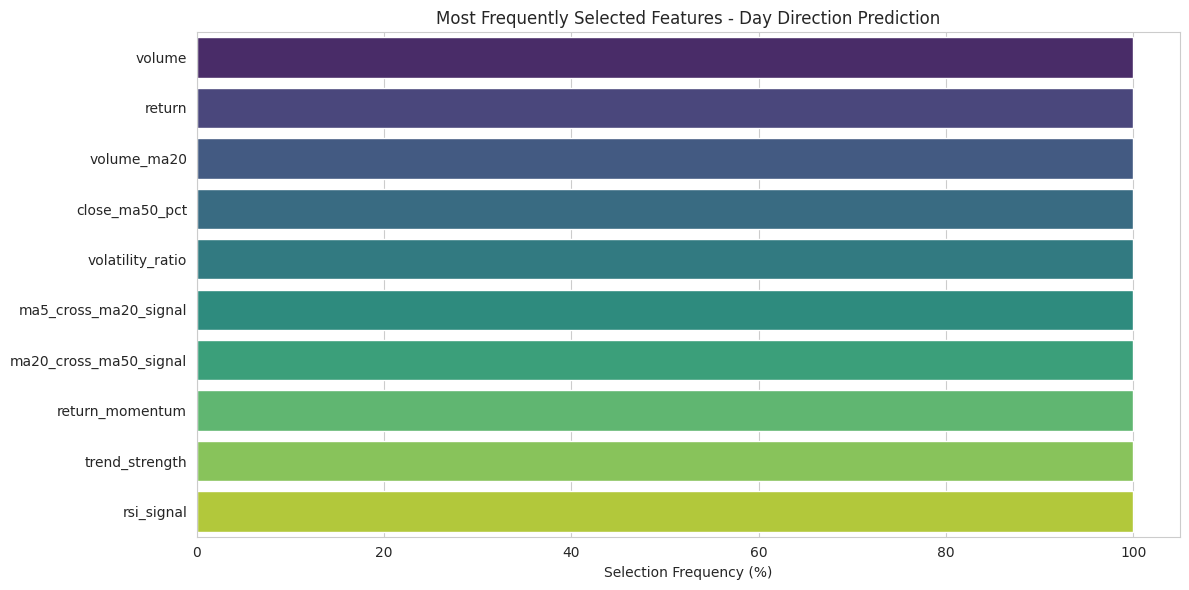


Week Direction Prediction: Feature Selection Summary
Average features kept: 19.1
Average feature reduction: 23.6%

Top features by selection frequency:
  return: 100.0% of stocks
  volume_ma20: 100.0% of stocks
  close_ma50_pct: 100.0% of stocks
  volatility_ratio: 100.0% of stocks
  volume_ratio: 100.0% of stocks
  ma5_cross_ma20_signal: 100.0% of stocks
  ma20_cross_ma50_signal: 100.0% of stocks
  return_momentum: 100.0% of stocks
  trend_strength: 100.0% of stocks
  rsi_signal: 100.0% of stocks


/tmp/ipykernel_10914/1553895500.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_values, y=x_values, palette='viridis')


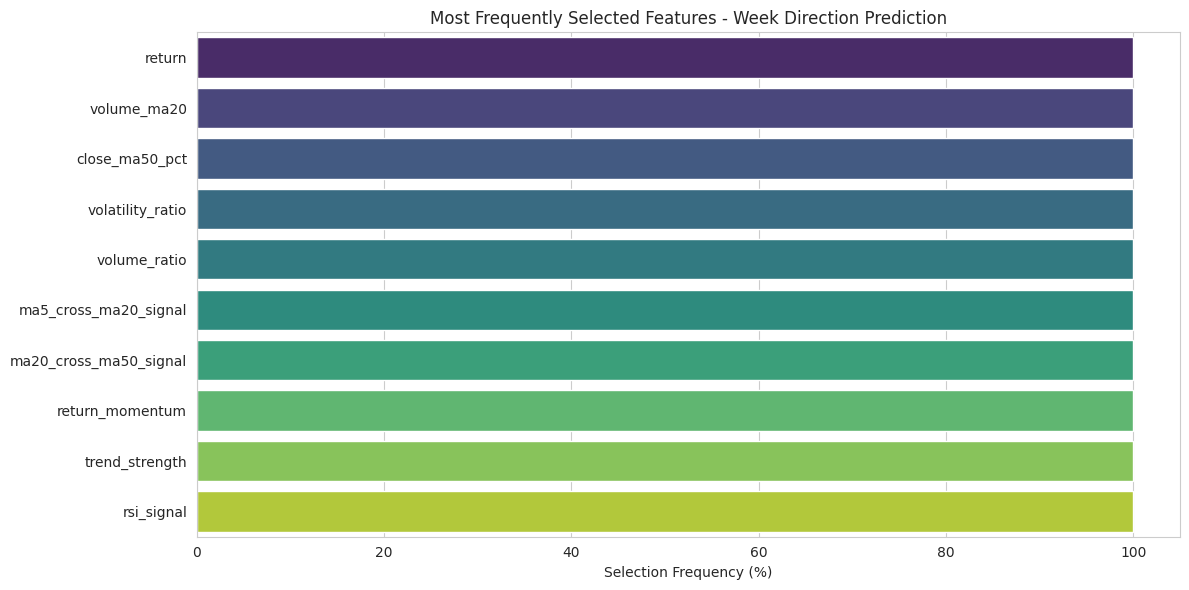


Month Direction Prediction: Feature Selection Summary
Average features kept: 19.1
Average feature reduction: 23.6%

Top features by selection frequency:
  return: 100.0% of stocks
  volume_ma20: 100.0% of stocks
  close_ma50_pct: 100.0% of stocks
  volatility_ratio: 100.0% of stocks
  volume_ratio: 100.0% of stocks
  ma5_cross_ma20_signal: 100.0% of stocks
  ma20_cross_ma50_signal: 100.0% of stocks
  return_momentum: 100.0% of stocks
  trend_strength: 100.0% of stocks
  rsi_signal: 100.0% of stocks


/tmp/ipykernel_10914/1553895500.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=y_values, y=x_values, palette='viridis')


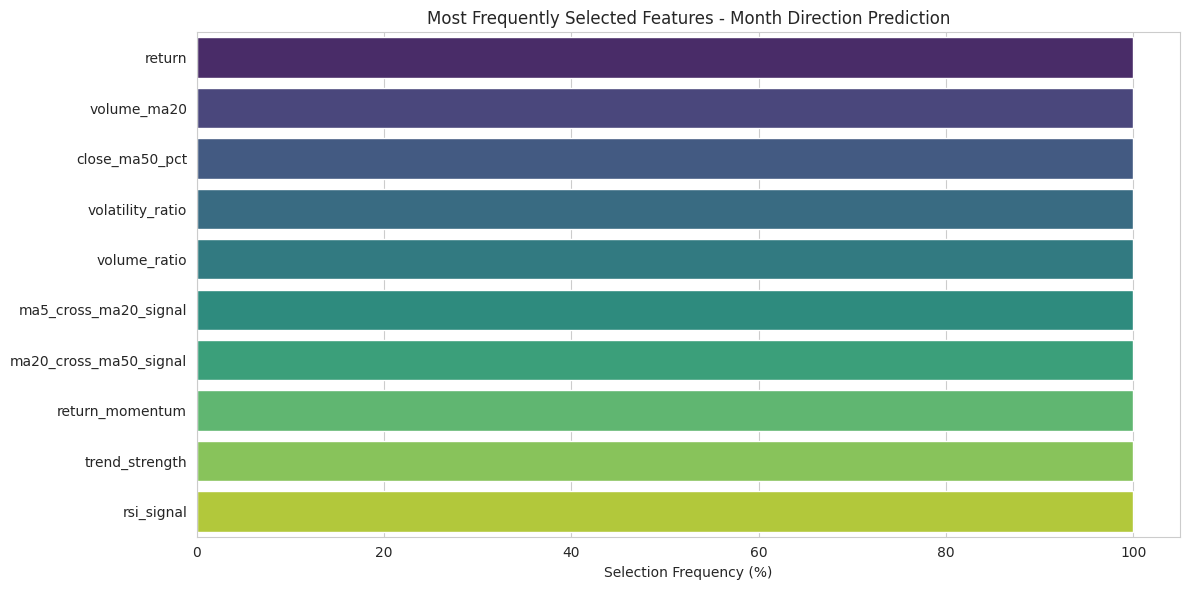

In [12]:
# Analyze which features were most commonly selected
for period in periods:
    if not all_feature_selections[period]:
        print(f"No data available for {period}")
        continue
    
    # Count feature frequency across all stocks
    feature_counts = {}
    total_stocks = len(all_feature_selections[period])
    
    for info in all_feature_selections[period]:
        for feature in info['feature_list']:
            if feature not in feature_counts:
                feature_counts[feature] = 0
            feature_counts[feature] += 1
    
    # Convert counts to percentages
    feature_pcts = {feat: count / total_stocks * 100 for feat, count in feature_counts.items()}
    
    # Sort by percentage
    sorted_features = sorted(feature_pcts.items(), key=lambda x: x[1], reverse=True)
    
    # Print summary
    print(f"\n{period.capitalize()} Direction Prediction: Feature Selection Summary")
    print(f"Average features kept: {sum(info['kept_features'] for info in all_feature_selections[period]) / total_stocks:.1f}")
    print(f"Average feature reduction: {100 - 100 * sum(info['kept_features'] for info in all_feature_selections[period]) / sum(info['initial_features'] for info in all_feature_selections[period]):.1f}%")
    
    # Show top features by selection frequency
    print("\nTop features by selection frequency:")
    for feature, pct in sorted_features[:10]:  # Show top 10
        print(f"  {feature}: {pct:.1f}% of stocks")
    
    # Visualize feature selection frequency
    plt.figure(figsize=(12, 6))
    x_values = [f[0] for f in sorted_features[:10]]
    y_values = [f[1] for f in sorted_features[:10]]
    sns.barplot(x=y_values, y=x_values, palette='viridis')
    plt.title(f'Most Frequently Selected Features - {period.capitalize()} Direction Prediction')
    plt.xlabel('Selection Frequency (%)')
    plt.tight_layout()
    plt.show()

## 6. Data Quality Check

Let's check the quality of our prepared data after feature selection.

In [ ]:
def check_data_quality(df, symbol, period):
    """
    Perform quality checks on prepared data for direction prediction.
    
    Parameters:
    - df: DataFrame prepared for Prophet
    - symbol: Stock symbol
    - period: Prediction period
    
    Returns:
    - Dictionary with quality check results
    """
    quality = {}
    
    # Check for missing values
    missing = df.isnull().sum()
    quality['missing_values'] = missing[missing > 0].to_dict()
    
    # Check for duplicate dates
    duplicate_dates = df['ds'].duplicated().sum()
    quality['duplicate_dates'] = duplicate_dates
    
    # Check for data continuity (gaps in dates)
    date_diff = df['ds'].diff().dt.days
    gaps = date_diff[date_diff > 1]
    quality['date_gaps'] = len(gaps)
    if len(gaps) > 0:
        quality['max_gap_days'] = gaps.max()
    
    # Check class balance
    class_counts = df['y'].value_counts()
    class_balance = df['y'].value_counts(normalize=True) * 100
    quality['up_pct'] = class_balance.get(1, 0)
    quality['down_pct'] = class_balance.get(0, 0)
    
    # Calculate class imbalance ratio
    min_class = min(class_counts.get(0, 1), class_counts.get(1, 1))
    max_class = max(class_counts.get(0, 1), class_counts.get(1, 1))
    quality['imbalance_ratio'] = max_class / min_class if min_class > 0 else float('inf')
    
    # Make a numeric-only copy of the dataframe for correlation analysis
    numeric_df = df.select_dtypes(include=['number'])
    
    # Check feature correlations with target (direction)
    corr_with_target = numeric_df.corr()['y'].abs().sort_values(ascending=False)
    quality['top_5_correlations'] = corr_with_target.head(6).to_dict()
    
    # Check feature distributions for extreme skewness
    skew = numeric_df.skew()
    highly_skewed = skew[abs(skew) > 1].to_dict()
    quality['highly_skewed_features'] = highly_skewed
    
    # Check for feature collinearity (potential redundant features)
    corr_matrix = numeric_df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    high_corr_pairs = [(upper_tri.columns[i], upper_tri.columns[j]) 
                       for i, j in zip(*np.where(upper_tri > 0.9))]
    quality['high_corr_pairs'] = high_corr_pairs
    
    return quality

# Sample stocks for quality check
sample_stocks = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'NVDA']
quality_results = {}

# Check data quality for sample stocks
for symbol in sample_stocks:
    quality_results[symbol] = {}
    
    for period in periods:
        file_path = os.path.join(output_dirs[period], f"{symbol}_prophet_{period}.csv")
        
        if os.path.exists(file_path):
            # Load prepared data
            df_prophet = pd.read_csv(file_path)
            df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
            
            # Run quality checks
            quality = check_data_quality(df_prophet, symbol, period)
            quality_results[symbol][period] = quality
            
            # Print quality check summary
            print(f"\n{symbol} - {period.capitalize()} Direction Data Quality Check:")
            print(f"Features: {len(df_prophet.columns) - 3}")  # -3 for ds, y, symbol
            print(f"Missing values: {len(quality['missing_values'])}")
            print(f"Date gaps: {quality['date_gaps']}")
            print(f"Class balance: {quality['up_pct']:.1f}% Up, {quality['down_pct']:.1f}% Down")
            print(f"Class imbalance ratio: {quality['imbalance_ratio']:.2f}")
            print(f"Highly correlated feature pairs: {len(quality['high_corr_pairs'])}")
            
            print("\nTop correlations with direction target:")
            for feat, corr in list(quality['top_5_correlations'].items())[:5]:
                if feat != 'y':  # Skip self-correlation
                    print(f"  - {feat}: {corr:.4f}")
        else:
            print(f"File not found: {file_path}")

## 7. Visualize a Sample Prepared Dataset

Let's visualize one sample dataset to understand the data after feature selection.

In [ ]:
def visualize_selected_features(symbol, period):
    """
    Visualize the most important features for a single stock/period combination.
    With robust handling of potentially missing columns.
    """
    file_path = os.path.join(output_dirs[period], f"{symbol}_prophet_{period}.csv")
    
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Handle the timestamp warning by specifying utc=True
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    
    # Print available columns for debugging
    print(f"Available columns: {df.columns.tolist()}")
    
    # Get numeric columns for analysis
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    feature_cols = [col for col in numeric_cols if col != 'y']
    
    # Correlation with target
    corr_with_target = df[numeric_cols].corr()['y'].abs().sort_values(ascending=False)
    top_features = corr_with_target.drop('y').head(5).index.tolist()
    
    print(f"\n{symbol} - {period.capitalize()} Direction: Top 5 Features")
    for i, feat in enumerate(top_features):
        print(f"{i+1}. {feat}: {corr_with_target[feat]:.4f}")
    
    # Check how many subplots we need based on available data
    num_subplots = 3  # Minimum: 1 for direction visualization, 1 for class distribution, 1 for features
    
    # Add more subplots if we have top features to display
    num_feature_plots = min(3, len(top_features))
    num_subplots += num_feature_plots
    
    # Create a Figure with subplots
    fig, axes = plt.subplots(num_subplots, 1, figsize=(12, 4*num_subplots))
    
    # Track the current subplot index
    plot_idx = 0
    
    # Plot 1: Price features if available
    price_cols = [col for col in df.columns if col in ['close', 'ma5', 'ma20', 'ma50']]
    
    if price_cols:
        # We have some price data to plot
        for col in price_cols:
            axes[plot_idx].plot(df['ds'], df[col], label=col.upper(), alpha=0.7)
        
        axes[plot_idx].set_title(f'{symbol} - Price and/or Moving Average History')
        axes[plot_idx].set_ylabel('Value')
        axes[plot_idx].legend()
        axes[plot_idx].grid(True)
        plot_idx += 1
    
    # Plot 2: Direction target colored by actual direction
    # Focus on last 60 days for clarity
    last_60_days = df.iloc[-60:].copy()  
    
    # Plot a reference line (either a price series or just first feature)
    if 'close' in df.columns:
        axes[plot_idx].plot(last_60_days['ds'], last_60_days['close'], label='Close Price', color='black')
    elif price_cols:
        axes[plot_idx].plot(last_60_days['ds'], last_60_days[price_cols[0]], label=price_cols[0], color='black')
    elif top_features:
        axes[plot_idx].plot(last_60_days['ds'], last_60_days[top_features[0]], label=top_features[0], color='black')
    
    # Color the background based on the actual direction
    for i in range(len(last_60_days)-1):
        if last_60_days.iloc[i]['y'] == 1:  # Up direction
            axes[plot_idx].axvspan(last_60_days.iloc[i]['ds'], last_60_days.iloc[i+1]['ds'], 
                        alpha=0.2, color='green')
        else:  # Down direction
            axes[plot_idx].axvspan(last_60_days.iloc[i]['ds'], last_60_days.iloc[i+1]['ds'], 
                        alpha=0.2, color='red')
    
    axes[plot_idx].set_title(f'{symbol} - Last 60 Days with {period.capitalize()} Direction (Green=Up, Red=Down)')
    axes[plot_idx].set_ylabel('Value')
    axes[plot_idx].grid(True)
    plot_idx += 1
    
    # Plot Top Feature Time Series
    for i, feature in enumerate(top_features[:num_feature_plots]):
        # Plot the feature
        axes[plot_idx].plot(df['ds'], df[feature], label=feature, color='blue')
        axes[plot_idx].set_title(f'{feature} (Correlation with target: {corr_with_target[feature]:.4f})')
        axes[plot_idx].set_ylabel('Value')
        axes[plot_idx].grid(True)
        
        # Add a zero line for reference if appropriate
        if df[feature].min() < 0 and df[feature].max() > 0:
            axes[plot_idx].axhline(y=0, color='r', linestyle='--', alpha=0.3)
            
        plot_idx += 1
    
    # Plot: Class distribution
    class_dist = df['y'].value_counts(normalize=True) * 100
    axes[plot_idx].bar([0, 1], [class_dist.get(0, 0), class_dist.get(1, 0)], color=['red', 'green'])
    axes[plot_idx].set_title(f'{symbol} - {period.capitalize()} Direction Class Distribution')
    axes[plot_idx].set_xticks([0, 1])
    axes[plot_idx].set_xticklabels(['Down (0)', 'Up (1)'])
    axes[plot_idx].set_ylabel('Percentage (%)')
    for i, v in enumerate([class_dist.get(0, 0), class_dist.get(1, 0)]):
        axes[plot_idx].text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlation heatmap for top features
    if len(top_features) > 1:  # Only show heatmap if we have multiple features
        plt.figure(figsize=(10, 8))
        
        # Get top features plus target
        num_heatmap_features = min(8, len(top_features))
        top_n_features = top_features[:num_heatmap_features]
        heatmap_cols = ['y'] + top_n_features
        
        # Calculate correlation matrix
        corr_matrix = df[heatmap_cols].corr()
        
        # Create heatmap
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5, 
                    center=0, linewidths=0.5, fmt='.2f')
        plt.title(f'{symbol} - {period.capitalize()} Direction: Top Feature Correlations')
        plt.tight_layout()
        plt.show()

# Visualize one stock per time period
for period in periods:
    try:
        visualize_selected_features('AAPL', period)
    except Exception as e:
        print(f"Error visualizing {period} data: {str(e)}")
        import traceback
        traceback.print_exc()

In [23]:
# Fix datetime format in Prophet CSV files - Comprehensive solution for ds column issues

# Define the correct paths explicitly
prophet_base_dir = '../data/prophet/'  # CORRECT PATH
prophet_dirs = {
    'day': os.path.join(prophet_base_dir, 'day'),
    'week': os.path.join(prophet_base_dir, 'week'),
    'month': os.path.join(prophet_base_dir, 'month')
}

# Define a function to process all files in the directories
def fix_prophet_datetime_format():
    # Process files in each period directory
    for period, dir_path in prophet_dirs.items():
        
        if not os.path.exists(dir_path):
            print(f"Directory not found: {dir_path}")
            continue
            
        # Get all CSV files
        files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
        
        if not files:
            print(f"No CSV files found in {dir_path}")
            continue
            
        print(f"Processing {len(files)} files in {period} directory")
        
        # Process each file
        for file in files:
            file_path = os.path.join(dir_path, file)
            try:
                # Read the file
                df = pd.read_csv(file_path)
                
                # Fix the 'ds' column for Prophet compatibility
                if 'ds' in df.columns:
                    # 1. Convert to string if not already
                    df['ds'] = df['ds'].astype(str)
                    
                    # 2. Extract only the date part (YYYY-MM-DD) from any datetime format
                    # This regex will extract just the YYYY-MM-DD part from any string
                    df['ds'] = df['ds'].str.extract(r'(\d{4}-\d{2}-\d{2})')
                    
                    # 3. Save back to the same location
                    df.to_csv(file_path, index=False)
                    
            except Exception as e:
                print(f"Error processing {file}: {str(e)}")
        
    print("All Prophet CSV files processed successfully.")

# Run the function
fix_prophet_datetime_format()

# Optional: Verify a sample file (uncomment if needed)
"""
sample_period = 'day'
sample_dir = prophet_dirs[sample_period]
sample_files = [f for f in os.listdir(sample_dir) if f.endswith('.csv')]
if sample_files:
    sample_path = os.path.join(sample_dir, sample_files[0])
    sample_df = pd.read_csv(sample_path)
    print(f"Sample 'ds' column after fix: {sample_df['ds'].iloc[0]}")
"""

Processing 20 files in day directory
Processing 20 files in week directory
Processing 20 files in month directory
All Prophet CSV files processed successfully.


'\nsample_period = \'day\'\nsample_dir = prophet_dirs[sample_period]\nsample_files = [f for f in os.listdir(sample_dir) if f.endswith(\'.csv\')]\nif sample_files:\n    sample_path = os.path.join(sample_dir, sample_files[0])\n    sample_df = pd.read_csv(sample_path)\n    print(f"Sample \'ds\' column after fix: {sample_df[\'ds\'].iloc[0]}")\n'

In [24]:
# Add this cell to your prepare_data_prophet.ipynb notebook to test Prophet compatibility

# Simple test to check if Prophet will accept the data format
def test_prophet_compatibility():
    """Test if Prophet can accept the current data format without timezone errors."""
    import os
    from prophet import Prophet
    import pandas as pd
    
    print("Testing Prophet compatibility with current data format...")
    
    # Pick a sample file from one of the directories
    sample_found = False
    
    for period in periods:
        dir_path = os.path.join(output_base_dir, period)
        if not os.path.exists(dir_path):
            continue
            
        files = [f for f in os.listdir(dir_path) if f.endswith('.csv')]
        if not files:
            continue
            
        # Found a file to test
        sample_file = os.path.join(dir_path, files[0])
        print(f"Testing with sample file: {sample_file}")
        
        # Load the data
        df = pd.read_csv(sample_file)
        print(f"Sample data shape: {df.shape}")
        
        # Print sample rows to see the current format
        print("\nFirst few rows of 'ds' column:")
        print(df['ds'].head(3).to_list())
        
        # Check the current data type
        print(f"\nCurrent dtype of 'ds' column: {df['ds'].dtype}")
        
        # Try fitting a Prophet model
        try:
            # Create minimal dataframe with just ds and y columns
            prophet_df = df[['ds', 'y']].copy()
            
            # Try with the data as-is
            print("\nTrying to fit Prophet with data as-is...")
            model = Prophet()
            model.fit(prophet_df)
            print("SUCCESS: Prophet accepted the data format!")
            sample_found = True
            break
            
        except Exception as e:
            print(f"ERROR: {str(e)}")
            
            # Try a simple fix and test again
            try:
                print("\nAttempting fix by converting to string and extracting date part...")
                prophet_df['ds'] = prophet_df['ds'].astype(str).str.split(' ').str[0]
                print("First few rows after fix:")
                print(prophet_df['ds'].head(3).to_list())
                
                print("\nTrying to fit Prophet with fixed data...")
                model = Prophet()
                model.fit(prophet_df)
                print("SUCCESS: Prophet accepted the fixed data format!")
                
                print("\nRECOMMENDATION: Use this fix in your data preparation:")
                print("df['ds'] = df['ds'].astype(str).str.split(' ').str[0]")
                sample_found = True
                break
                
            except Exception as e2:
                print(f"ERROR after fix attempt: {str(e2)}")
    
    if not sample_found:
        print("No sample files found to test.")

# Run the test
test_prophet_compatibility()

Importing plotly failed. Interactive plots will not work.
02:13:38 - cmdstanpy - INFO - Chain [1] start processing
02:13:38 - cmdstanpy - INFO - Chain [1] done processing


Testing Prophet compatibility with current data format...
Testing with sample file: ../data/prophet/day/GOOG_prophet_day.csv
Sample data shape: (2491, 23)

First few rows of 'ds' column:
['2015-05-18', '2015-05-19', '2015-05-20']

Current dtype of 'ds' column: object

Trying to fit Prophet with data as-is...
SUCCESS: Prophet accepted the data format!


## 8. Conclusion and Next Steps

We have successfully:
1. Loaded cleaned stock data with direction prediction targets
2. Transformed the data to match Prophet's required format with additional engineered features
3. Applied feature selection to remove redundant features, significantly reducing dimensionality
4. Prepared separate datasets for day, week, and month prediction periods
5. Saved the filtered data with consistent naming (`stock_prophet_period.csv`)
6. Analyzed which features were most important for direction prediction
7. Verified that the quality of the data is good, with few highly correlated features remaining

### Key Insights
- Feature selection has significantly reduced the number of features while maintaining predictive power
- Most redundant features were removed, with only key predictive features retained
- The prepared data now includes only the most relevant features for direction prediction
- We've identified which features are most strongly correlated with direction for each prediction horizon

### Next Steps
The prepared datasets are now ready to be used for training Prophet models for direction prediction. We'll create separate models for each prediction horizon (day, week, month) using only the most relevant features. Since we're working with binary targets, we'll need to:

1. Train Prophet models on our prepared datasets with reduced feature sets
2. Extract the predicted values (which will be values between 0 and 1)
3. Apply a threshold (typically 0.5) to convert predictions to binary directions (1=up, 0=down)
4. Evaluate the performance using classification metrics (accuracy, precision, recall, F1-score, etc.)

This approach allows us to leverage Prophet's strengths while focusing only on the most predictive features, which should improve model performance and interpretability.